# Kauno miesto  orų ir avarijų atvirų duomenų analizė

Data: 2019-12-03

Autorius: © 2019 [Mantas Bukauskas](https://www.linkedin.com/in/mantas-bukauskas-359122125/), bukauskasmant@gmail.com. 

## Analizė atsako į šiuos klausimus:
1. [Kurios orų stotelės duomenys tinkamiausi pasirinktame geografiniame taške](#Kurios-orų-stotelės-duomenys-tinkamiausi-pasirinktame-geografiniame-taške?)?
1. [Kokie orai buvo pastaruosiu 3 metus valandos tikslumu](#Kokie-orai-buvo-pastaruosius-3-metus-3-valandų-tikslumu?)?
1. [Ar snigs](#Ar-snigs?-(kNN))? (kNN)(MM)
1. [Ar lis](#Ar-lis?-(Decision-Trees))? (Decision Trees)(MM2)
1. [Kokie oro parametrai labiausiai įtakoja eismo avarijas](#Kokie-oro-parametrai-labiausiai-įtakoja-eismo-avarijas?-(xgBoost))? (xgBoost)(MM2)
1. [Kokia tikimybė, kad tam tikrą valandą, esant duotoms oro sąlygoms įvyks eismo avarija Kauno mieste](#Kokia-tikimybė,-kad-tam-tikrą-valandą,-esant-duotoms-oro-sąlygoms-įvyks-eismo-avarija-Kauno-mieste?-(xgBoost))? (xgBoost)(MM2)

## Pasitelkiami duomenų šaltiniai:
* [https://rp5.ru/Weather_in_Lithuania](https://rp5.ru/Weather_in_Lithuania)
* [https://www.epolicija.lt/atviri-duomenys](https://www.epolicija.lt/atviri-duomenys)

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [1]:
import requests
import io
import geopandas as gpd
import geoplot
from shapely.geometry import Point, LineString, Polygon
import gzip
import shutil
import json
import time
import pandas as pd
import os
import numpy as np
import pytess
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline


Nustatome duomenų šaltinio kintamuosius:

In [2]:
urlSession = 'https://rp5.ru/Weather_in_Lithuania'
urlStationMap = 'http://rp5.ru/responses/reGmap.php'
urlStationProg = 'http://rp5.ru/responses/reFileSynop.php'
urlAirportProg = 'http://rp5.ru/responses/reFileMetar.php'

Sukuriame WEB sesiją:

In [3]:
resp = requests.get(urlSession)
phpSession = resp.cookies['PHPSESSID']
print(phpSession)

56b4bc3b413769986a469838b8460bca


Atsiunčiame stotelių duomenis:

In [4]:
head = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
    'Origin': 'https://rp5.ru',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Referer': 'https://rp5.ru/',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Accept': '*/*',
    'X-Requested-With': 'XMLHttpRequest'
}
cookies = {
    'PHPSESSID': phpSession
}
postBody = {
    'ENTER': 'TRUE',
    'ID': 33,
    'ZOOM': 7,
    'coords[sw_lat]': 53.46,
    'coords[sw_lng]': 19.64,
    'coords[ne_lat]': 56.61,
    'coords[ne_lng]': 28.43,
    'l': 1
}
res = requests.post(urlStationMap, data=postBody, headers=head, cookies=cookies)
print (res.text)

{"point_id0":"9821","latit0":"56.5175","longt0":"21.0969","t0":"7","tcolor0":"red","lang0":{"1":"Weather_archive_on_Liepaja_(airport),_METAR","2":"\u0410\u0440\u0445\u0438\u0432_\u043f\u043e\u0433\u043e\u0434\u044b_\u0432_\u041b\u0438\u0435\u043f\u0430\u0435_(\u0430\u044d\u0440\u043e\u043f\u043e\u0440\u0442),_METAR","3":"\u0410\u0440\u0445\u0456\u0432_\u043f\u043e\u0433\u043e\u0434\u0438_\u0432_\u041b\u0456\u0454\u043f\u0430\u0457_(\u0430\u0435\u0440\u043e\u043f\u043e\u0440\u0442),_METAR","4":"Arhiva_meteo_\u00een_Liepaja_(aeroport),_METAR","8":"METAR\u5229\u8036\u5e15\u4e9a(\u673a\u573a)\u5386\u53f2\u5929\u6c14_","10":"Wetterarchiv_in_Liepaja_(Flughafen),_METAR","12":"Laika_apst\u0101k\u013cu_arh\u012bvs_Liep\u0101j\u0101_(lidosta),_METAR","15":"Archives_m\u00e9t\u00e9o_\u00e0_Liepaja_(a\u00e9roport),_METAR","17":"Archivo_de_tiempo_en_Liepaja_(aeropuerto),_METAR","18":"Arquivo_de_tempo_em_Liepaja_(aeroporto),_METAR","19":"\u0410\u0440\u0445\u0456\u045e_\u043d\u0430\u0434\u0432\u043e\u

Transformuojame rezultatus į Python _dict_ objektą:

In [5]:
jsonStations = json.loads(res.text)
stations = []
for i in range(0, 100):
    idx = str(i)
    id = None
    try:
        id = jsonStations['point_id'+idx]
    except KeyError:
        pass
    if (id is not None):
        stations.append({
            'stationid': id,
            'long': jsonStations['longt'+idx],
            'lat': jsonStations['latit'+idx],
            'town': jsonStations['town'+idx]['1'],
            'name': jsonStations['lang'+idx]['1'],
            'currentT': jsonStations['t'+idx]
        })

Transformuojame rezultatus į pandas DataFrame ir išsaugome kaip CSV:

In [6]:
dfStations = pd.DataFrame.from_dict(stations)
dfStations.set_index('stationid')
dfStations.to_csv(r'oru_stoteles.csv')

In [7]:
dfStations.tail(20)

,stationid,long,lat,town,name,currentT
12,7862,21.3667,54.0667,Ketrzyn,Weather_archive_in_Ketrzyn,5
13,7864,22.9500,54.1333,Suwalki,Weather_archive_in_Suwalki,3
14,7885,20.4847,53.7767,Olsztyn,Weather_archive_in_Olsztyn,5
15,7888,21.5833,53.7833,Mikolajki,Weather_archive_in_Mikolajki,5
16,9826,24.2167,56.4000,Bauska,Weather_archive_in_Bauska,4
17,9828,25.9167,56.5167,Zilani,Weather_archive_in_Zilani,2
18,9829,27.3333,56.5000,Rezekne,Weather_archive_in_Rezekne,1
19,9832,22.2500,55.9667,Telsiai,Weather_archive_in_Telsiai,5
20,9835,23.3167,55.9333,Siauliai,Weather_archive_in_Siauliai,4
21,9836,24.3833,55.7500,Panevezys,Weather_archive_in_Panevezys,2


## Kurios orų stotelės duomenys tinkamiausi pasirinktame geografiniame taške?

Voronojaus poligonai leidžia nustatyti orų stotelei artimiausią plotą. Taip galima nustatyti kuri orų stotelė geriausiai tinka orų nustatymui tame plote.

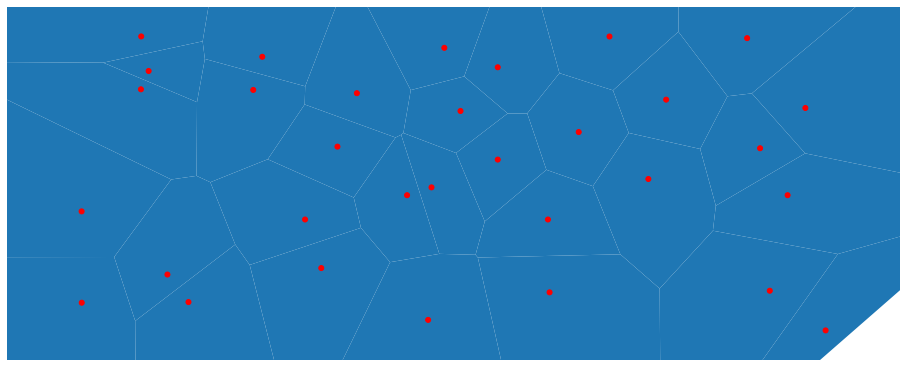

In [8]:
# Nuskaitome duomenis
df_stations = pd.read_csv(r'oru_stoteles.csv')

# Sukuriame geopandas GeoDataFrame
gdfStations = gpd.GeoDataFrame(df_stations, geometry=[Point(x, y) for x, y in zip(df_stations.long, df_stations.lat)])

# Sukuriame Voronojau poligonus
voronoipolys = pytess.voronoi([(x, y) for x, y in zip(df_stations.long, df_stations.lat)])
polygons = [Polygon(voronoipolys[i][1]) for i in range(len(voronoipolys)-1)]

# Sukuriame geopandas GeoDataFrame iš Voronojaus poligonų
poly_df = gpd.GeoDataFrame(geometry=polygons)

# Atliekame geografinę sankirtą su orų stotelėmis
polyStations = gpd.sjoin(poly_df, gdfStations, how='inner', op='intersects', lsuffix='left', rsuffix='right')

# Paruošiame plokštumą diagramoje su Voronojaus poligonais
ax = polyStations.plot(figsize=(16, 8))

# Brėžiame diagramą su Voronojaus poligonų ir taškų plokštumomis
geoplot.pointplot(gdfStations, color='red', ax=ax)

In [9]:
# Pašaliname perteklinius stulpelius
polyStations = polyStations.drop(columns=['index_right'])

Atrenkame mūsų pasirinktame taške geriausiai tinkančią orų stotelę:

In [10]:
# Sukuriame geopandas GeoDataFrame su mus dominančiais taškais
gdfEvents = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in [(23.923180, 54.903264)]])

# Atliekame geometrinę sankirtą, gauname tinamiausias orų stoteles
eventStations = gpd.sjoin(polyStations, gdfEvents, how='inner', op='intersects', lsuffix='left', rsuffix='right')
eventStations.tail()

,geometry,Unnamed: 0,stationid,long,lat,town,name,currentT,index_right
8,"POLYGON ((24.16551667086167 54.27945246830494,...",25,9845,23.8333,54.8833,Kaunas,Weather_archive_in_Kaunas,4,0


## Kokie orai buvo pastaruosius 3 metus valandos tikslumu?

Atsiunčiame Kauno miesto orų duomenis:

In [11]:
# Sukuriame sesija
resp = requests.get('http://rp5.ru/Weather_archive_in_Kaunas')
phpSession = resp.cookies['PHPSESSID']
print(phpSession)

5b8358fc9387d30f7f69af266d2bbdf9


Atsisiunčiame orų stotelių duomenis:

In [12]:
# Duomenų laikotarpis 
datefrom = '01.01.2016'
dateto = '01.01.2019'

# Užklausos parametrai
head = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
    'Origin': 'https://rp5.ru',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Referer': 'https://rp5.ru/',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Accept': '*/*',
    'X-Requested-With': 'XMLHttpRequest'
}
cookies = {
    'PHPSESSID': phpSession
}

# Orų duomenų atsisiuntimas
for station in [{'no': 26629, 'isMetar': False, 'name': 'Weather_archive_in_Kaunas'}]:
    if station['isMetar']:
        data = {
            'metar': str(station['no']),
            'a_date1': datefrom,
            'a_date2': dateto,
            'f_ed3': '9',
            'f_ed4': '9',
            'f_ed5': '19',
            'f_pe': '1',
            'f_pe1': '2',
            'lng_id': '1'
        }
        url = urlAirportProg
    else:
        data = {
            'wmo_id': str(station['no']),
            'a_date1': datefrom,
            'a_date2': dateto,
            'f_ed3': '9',
            'f_ed4': '9',
            'f_ed5': '19',
            'f_pe': '1',
            'f_pe1': '2',
            'lng_id': '1'
        }
        url = urlStationProg
    res = requests.post(url, data=data, headers=head, cookies=cookies)
    content = res.text
    print(res.text)
    try:
        start = content.index('href=')
        end = content.index('>Download')
        dataurl = content[start+5:end]
        dataurl = dataurl.replace('../', '')
        print(dataurl)
        datareq = requests.get(dataurl)
        wdzip = r'weather_' + str(station['no']) + '.gz'
        wdcsv = r'weather_' + str(station['no']) + '.csv'
        with open(wdzip, 'wb') as wdfile:
            wdfile.write(datareq.content)
        #Extract gzip
        with gzip.open(wdzip, 'rb') as f_in:
            with open(wdcsv, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    except Exception as e:
        print('Failed due to error')
        print(e)

    <script type="text/javascript">
        $("#f_result").empty().append('<a href=http://37.200.66.117/../download/files.synop/26/26629.01.01.2016.01.01.2019.1.0.0.en.utf8.00000000.csv.gz>Download</a>').css("display","none").css('opacity',0).css("display","block").animate({opacity:"1"},1500);
    </script>
    
http://37.200.66.117/download/files.synop/26/26629.01.01.2016.01.01.2019.1.0.0.en.utf8.00000000.csv.gz


Nuskaitome atsisiųstą CSV failą, pervadiname stulpelius:

In [13]:
dfWeather = pd.read_csv('weather_26629.csv', sep=';', index_col=False, parse_dates=[0], skiprows=6)
dfWeather.rename(columns={"Local time in Kaunas": "datetime"},inplace=True)
dfWeather.rename(columns={"ff3": "MaxGustSpeedOnGround"},inplace=True)
dfWeather.rename(columns={"ff10": "MaxGustSpeedInSky"},inplace=True)
dfWeather.rename(columns={"VV": "HorizontalVisibility"},inplace=True)
dfWeather.rename(columns={"Td": "DewpointTemp"},inplace=True)
dfWeather.rename(columns={"RRR": "PrecipitationAmountMM"},inplace=True)
dfWeather.rename(columns={"Local time in Kaunas": "datetime"},inplace=True)
dfWeather.drop(['MaxGustSpeedInSky','Po','Pa','DD','Ff','N','W2','Cl','Tn','Tx','Nh','H','Cm','Ch','tR','Tg','E','E\'','sss'],axis=1,inplace=True)

In [14]:
dfWeather.head(3)

,datetime,T,P,U,MaxGustSpeedOnGround,WW,W1,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM
0,2019-01-01 23:00:00,3.2,745.9,95.0,10.0,Rain (not freezing) not falling as shower(s).,Rain.,20.0,2.5,NaN
1,2019-01-01 20:00:00,3.1,746.0,95.0,12.0,"Rain, not freezing, continuous, slight at time...",Rain.,8.0,2.3,7.0
2,2019-01-01 17:00:00,3.9,746.6,91.0,14.0,Rain (not freezing) not falling as shower(s).,Rain.,20.0,2.5,NaN


Aproksimuojame orus valandos tikslumu:

In [15]:
#Funkcija konvertuoti orų duomenims į loginį kintamajį.
def isSnowing(x):
    try:
        p = x.lower().index('snow')
        return 1
    except:
        pass
    return 0

#Funkcija konvertuoti orų duomenims į loginį kintamajį.
def isRaining(x):
    try:
        p = x.lower().index('rain')
        return 1
    except ValueError:
        pass
    try:
        p = x.lower().index('drizzle')
        return 1
    except ValueError:
        pass
    return 0

# Funkcija reikšmių konvertavimui į Float tipo kintamąjį arba None
def toFloat(x):
    try:
        return float(x)
    except ValueError:
        return None

Aprodojame ir išsaugome rinkinį:

In [16]:
# 1. Pritaikome funkcija konvertuoti tekstinį lauką į loginį parametrą.
dfWeather['snowing'] = dfWeather.W1.apply(isSnowing)
dfWeather['raining'] = dfWeather.WW.apply(isRaining)
dfWeather.drop(['W1', 'WW'],axis=1,inplace=True)
# 2. Pašaliname nenaudojamus stulpelius.
# 3. Pašaliname laike besidubliuojančius įrašus.
dfWeather['datetime'] = pd.to_datetime(dfWeather.datetime)
dfWeather.drop_duplicates(subset='datetime',inplace=True)
# 4. Nustatome datos lauką kaip indekso lauką.
dfWeather.set_index('datetime', inplace=True)
# 5. Išsaugome gautą duomenų rinkinį į CSV.
dfWeather.to_csv(r'weather_processed_26629.csv')

Konvertuojam duomenis į Float ir užpildome neegzistuojančias (None) reikšmes:

In [17]:
columns = list(dfWeather)
for c in columns: 
    dfWeather[c] = dfWeather[c].apply(toFloat)
dfWeather.fillna(dfWeather.mean(),inplace=True)

In [18]:
dfWeather.tail()

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2016-01-01 14:00:00,-8.4,775.7,80.0,4.00000,19.0,-11.2,3.346526,1.0,0.0
2016-01-01 11:00:00,-8.8,776.2,89.0,4.00000,16.0,-10.3,3.346526,1.0,0.0
2016-01-01 08:00:00,-10.3,775.9,90.0,1.00000,8.0,-11.6,3.346526,1.0,0.0
2016-01-01 05:00:00,-11.2,775.9,90.0,2.00000,8.0,-12.5,3.346526,1.0,0.0
2016-01-01 02:00:00,-15.4,776.3,90.0,7.28947,4.6,-16.7,3.346526,0.0,0.0


Atliekame interpoliaciją ir gauname duomenis valandos tikslumu:

In [19]:
dfWeather = dfWeather.reindex(pd.date_range("2016-01-01", dfWeather.index.max(), freq = "H"))
dfWeather['T'] = dfWeather['T'].interpolate(method='time').ffill().bfill()
dfWeather['U'] = dfWeather['U'].interpolate(method='time').ffill().bfill()
dfWeather['P'] = dfWeather['P'].interpolate(method='time').ffill().bfill()
dfWeather['MaxGustSpeedOnGround'] = dfWeather['MaxGustSpeedOnGround'].interpolate(method='time').ffill().bfill()
dfWeather['HorizontalVisibility'] = dfWeather['HorizontalVisibility'].interpolate(method='time').ffill().bfill()
dfWeather['DewpointTemp'] = dfWeather['DewpointTemp'].interpolate(method='time').ffill().bfill()
dfWeather['PrecipitationAmountMM'] = dfWeather['PrecipitationAmountMM'].interpolate(method='time').ffill().bfill()
dfWeather['raining'] = dfWeather['raining'].interpolate(method='index').ffill().bfill()
dfWeather['snowing'] = dfWeather['snowing'].interpolate(method='index').ffill().bfill()

In [20]:
# wdf.loc[rain_rows_idx, 'raining'] = 1
dfWeather.loc[dfWeather['raining'] >= 0.5, 'raining'] = 1
dfWeather.loc[dfWeather['snowing'] >= 0.5, 'snowing'] = 1
dfWeather.loc[dfWeather['raining'] < 0.5, 'raining'] = 0
dfWeather.loc[dfWeather['snowing'] < 0.5, 'snowing'] = 0

In [21]:
dfWeather.tail()

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.0,2.366667,5.782175,0.0,1.0
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.0,2.300000,7.000000,0.0,1.0
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.0,2.366667,5.782175,0.0,1.0
2019-01-01 22:00:00,3.166667,745.933333,95.000000,10.666667,16.0,2.433333,4.564350,0.0,1.0
2019-01-01 23:00:00,3.200000,745.900000,95.000000,10.000000,20.0,2.500000,3.346526,0.0,1.0


In [22]:
dfWeather.index.name = 'datetime'
dfWeather.to_csv(r'oras_kaune_kas_valanda.csv')
dfWeather

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2016-01-01 00:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0
2016-01-01 01:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0
2016-01-01 02:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0
2016-01-01 03:00:00,-14.000000,776.166667,90.000000,5.526314,5.733333,-15.300000,3.346526,0.0,0.0
2016-01-01 04:00:00,-12.600000,776.033333,90.000000,3.763157,6.866667,-13.900000,3.346526,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0


## Ar snigs? (kNN)

Konvertuojam duomenis į Float ir užpildome neegzistuojančias (None) reikšmes:

Patikriname kokie parametrai buvo sniego metu:

In [23]:
dfWeather[dfWeather['snowing'] == 1].tail(100)

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2018-12-22 09:00:00,0.633333,750.866667,97.000000,7.192980,7.000000,0.2,1.715509,1.0,1.0
2018-12-22 10:00:00,0.766667,750.533333,97.000000,7.096490,7.000000,0.3,2.531017,1.0,0.0
2018-12-22 11:00:00,0.900000,750.200000,97.000000,7.000000,7.000000,0.4,3.346526,1.0,0.0
2018-12-22 12:00:00,0.866667,749.833333,96.333333,6.666667,6.333333,0.3,3.346526,1.0,0.0
2018-12-22 13:00:00,0.833333,749.466667,95.666667,6.333333,5.666667,0.2,3.346526,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2019-01-01 11:00:00,1.700000,752.100000,95.000000,14.000000,3.000000,1.0,3.346526,1.0,1.0
2019-01-01 12:00:00,2.300000,750.733333,95.000000,14.333333,5.000000,1.6,3.346526,1.0,1.0
2019-01-01 13:00:00,2.900000,749.366667,95.000000,14.666667,7.000000,2.2,3.346526,1.0,1.0


Patikriname įvykių skaičius kai buvo fiksuotas sniegas:

In [24]:
dfWeather[dfWeather['snowing'] == 1].shape

(2523, 9)

Visų fiksuotų orų įrašų skaičius nagrinėjamu laikotarpiu:

In [25]:
dfWeather.shape

(26328, 9)

Atliekame mašininį mokymą. Atskiriame nagrinėjamą klasę (sniegą) ir likusius atributus:

In [26]:
columns = dfWeather.columns.tolist()
# Pašaliname lietaus ir sniego prognozę
columns_count = range(len(columns)-3)
y_snow = dfWeather['snowing'].values
x_snow = dfWeather.values[:, columns_count]

print(x_snow[1])
dfWeather.head(1)

[-15.4        776.3         90.           7.28947034   4.6
 -16.7       ]


,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2016-01-01,-15.4,776.3,90.0,7.28947,4.6,-16.7,3.346526,0.0,0.0


Išskaidome rinkinį į apmokymo ir testavimo rinkinius (santykiu 20%:80%):

In [27]:
x_train_snow, x_test_snow, y_train_snow, y_test_snow = train_test_split(x_snow, y_snow, test_size=0.2, random_state=42, stratify=y_snow)


```
_stratify_. This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
```

Apmokome modelį su skirtingomis k reikšmėmis ir tikriname, kada tikslumas geriausias:

In [28]:
# https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,10)
scores = {}
scores_list = []
for k in k_range:
    # Sukuria KNN klasifikatorių
    knn = KNeighborsClassifier(n_neighbors = k)
    # Apmoko klasifikatorių su mokymui skirtais duomenimis
    knn.fit(x_train_snow,y_train_snow)
    # Testuoja klasifikatorių su testavimo duomenimis
    y_pred_snow = knn.predict(x_test_snow)
    # Išsaugo tikslumo metrikas
    scores[k] = metrics.accuracy_score(y_test_snow,y_pred_snow)
    scores_list.append(metrics.accuracy_score(y_test_snow, y_pred_snow))

Atvaizduojame rezultatus grafiku:

Text(0, 0.5, 'Tikslumas')

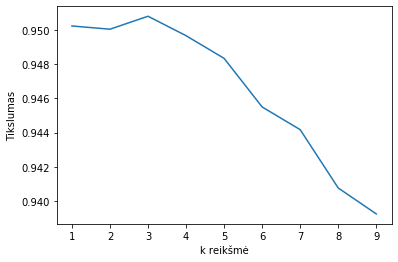

In [29]:
plt.plot(k_range, scores_list)
plt.xlabel('k reikšmė')
plt.ylabel('Tikslumas')

Apmokome modelį su geriausia k reikšme:

In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(x_train_snow,y_train_snow)
knn.score(x_test_snow, y_test_snow)

0.9508165590581086

Naudojame modelį snygiui nuspėti. Tam paduodame esamus ar būsimus oro parametrus:

In [31]:
knn.predict([[-3, 758, 100, 4, 5, -8]])

array([1.])

## Ar lis? (Decision Trees)

In [32]:
dfWeather[dfWeather['raining'] == 1].shape

(4313, 9)

In [33]:
dfWeather[dfWeather['raining'] == 1]

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2016-01-02 01:00:00,-2.200000,758.566667,82.000000,11.000000,18.666667,-4.833333,3.346526,0.0,1.0
2016-01-02 02:00:00,1.600000,749.100000,87.000000,13.000000,19.000000,-0.300000,3.346526,0.0,1.0
2016-01-02 03:00:00,1.433333,749.233333,89.333333,12.666667,19.333333,-0.100000,3.346526,0.0,1.0
2016-01-02 04:00:00,1.266667,749.366667,91.666667,12.333333,19.666667,0.100000,3.346526,1.0,1.0
2016-01-02 05:00:00,1.100000,749.500000,94.000000,12.000000,20.000000,0.300000,3.346526,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0


In [34]:
columns = dfWeather.columns.tolist()
# Pašaliname lietaus ir sniego prognozę
columns_count = range(len(columns)-3)
y_rain = dfWeather['raining'].values
x_rain = dfWeather.values[:, columns_count]

print(x_rain[1])
dfWeather.head(1)

[-15.4        776.3         90.           7.28947034   4.6
 -16.7       ]


,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining
datetime,,,,,,,,,
2016-01-01,-15.4,776.3,90.0,7.28947,4.6,-16.7,3.346526,0.0,0.0


In [35]:
x_train_rain, x_test_rain, y_train_rain, y_test_rain = train_test_split(x_rain, y_rain, test_size=0.2, random_state=42, stratify=y_rain)

In [36]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_rain, y_train_rain)
clf.score(x_test_rain, y_test_rain)

0.8663121914166351

In [37]:
clf.predict([[5, 746, 100, 4, 5, 8]])

array([1.])

## MP2. Oro ir avarijų sąryšio Kauno mieste tyrimas

Nuskaitome avarijų duomenis:

In [38]:
df1 = pd.io.excel.read_excel(r'./eiis_2016-LT.xls', parse_dates=False)   
df1.head(10)

,Savivaldybė,Data,Laikas,Registro kodas,Įvykio rūšis,Unnamed: 5,Unnamed: 6,Dalyvių skaičius,Žuvusių skaičius,Sužeistų skaičius,...,Unnamed: 62,Sveikatos sutrikdymo mastas,Vairuotojo kvalifikacija,Vairavimo stažas metais,Eismo įvykio dalyvio būsena,Unnamed: 67,Unnamed: 68,Unnamed: 69,"Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)",Transporto priemonės ID.1
0,Akmenės r. sav.,2016-05-07,15:15:00,07-16-9427588,Susidūrimas,Susidūrimai judant ta pačia kryptimi,Atsitrenkimas į galą,3.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas ambulatoriškai,NaN,Atitinka,8.0,Blaivus,NaN,NaN,NaN,0.0,30766008.0
5,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,10.0,Blaivus,NaN,NaN,NaN,0.0,30766009.0
6,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,15.0,Blaivus,NaN,NaN,NaN,1.0,30766011.0
7,Akmenės r. sav.,2016-05-19,17:10:00,07-16-9428273,Užvažiavimas ant pėsčiojo,"Užvažiavimas ant pėsčiojo, kai nėra perėjos",Pėsčiasis išėjo iš už sustojančios arba lėčiau...,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,40.0,Blaivus,NaN,NaN,NaN,0.0,30770229.0


In [39]:
df2 = pd.io.excel.read_excel(r'./eiis_2017-LT.xls', parse_dates=False)   
df2.head(10)

,Savivaldybė,Data,Laikas,Registro kodas,Įvykio rūšis,Unnamed: 5,Unnamed: 6,Dalyvių skaičius,Žuvusių skaičius,Sužeistų skaičius,...,Unnamed: 62,Sveikatos sutrikdymo mastas,Vairuotojo kvalifikacija,Vairavimo stažas metais,Eismo įvykio dalyvio būsena,Unnamed: 67,Unnamed: 68,Unnamed: 69,"Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)",Transporto priemonės ID.1
0,Akmenės r. sav.,2017-02-24,15:23:00,07-17-9445493,Užvažiavimas ant pėsčiojo,"Užvažiavimas ant pėsčiojo, kai nėra perėjos","Kiti užvažiavimai ant pėsčiojo, kai nėra perėjos",2.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,16.0,Blaivus,NaN,NaN,NaN,1.0,31018324.0
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Blaivus,NaN,NaN,NaN,0.0,NaN
4,Akmenės r. sav.,2017-03-15,07:57:00,07-17-9446419,Apvirtimas,Nuvažiavimai nuo kelio,"Nuvažiavimai nuo kelio į kairę, kai kelio ving...",1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,22.0,Blaivus,NaN,NaN,NaN,1.0,31018367.0
7,Akmenės r. sav.,2017-04-01,19:12:00,07-17-9447279,Apvirtimas,Nuvažiavimai nuo kelio,Nuvažiavimai nuo kelio į kairę tiesiame ruože,6.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas stacionare,NaN,NaN,NaN,Blaivus,NaN,NaN,NaN,0.0,30883744.0


In [40]:
df3 = pd.io.excel.read_excel(r'./eiis_2018-LT.xls', parse_dates=False)   
df3.head(10)

,Savivaldybė,Data,Laikas,Registro kodas,Įvykio rūšis,Unnamed: 5,Unnamed: 6,Dalyvių skaičius,Žuvusių skaičius,Sužeistų skaičius,...,Unnamed: 62,Sveikatos sutrikdymo mastas,Vairuotojo kvalifikacija,Vairavimo stažas metais,Eismo įvykio dalyvio būsena,Unnamed: 67,Unnamed: 68,Unnamed: 69,"Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)",Transporto priemonės ID.1
0,Akmenės r. sav.,2018-04-07,19:47:00,07-18-9469567,Kiti eismo įvykiai,Nuvažiavimai nuo kelio,"Nuvažiavimai nuo kelio į dešinę, kai kelio vin...",3.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,0.0,Blaivus,NaN,NaN,NaN,1.0,31096839.0
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Blaivus,NaN,NaN,NaN,0.0,31096839.0
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas stacionare,Nežymus sveikatos sutrikdymas,NaN,NaN,Blaivus,NaN,NaN,NaN,0.0,31096839.0
5,Akmenės r. sav.,2018-04-13,14:25:00,07-18-9469966,Susidūrimas,Kiti susidūrimai,"Susidūrimas sukant vienai TP į kairę, kitai į ...",4.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas stacionare,Nesunkus sveikatos sutrikdymas,Atitinka,14.0,Blaivus,NaN,NaN,NaN,1.0,31262976.0
9,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Atitinka,12.0,Blaivus,NaN,NaN,NaN,1.0,31262977.0


In [41]:
dfAccident = None
dfAccident = pd.concat([df1, df2, df3])
dfAccident

,Savivaldybė,Data,Laikas,Registro kodas,Įvykio rūšis,Unnamed: 5,Unnamed: 6,Dalyvių skaičius,Žuvusių skaičius,Sužeistų skaičius,...,Unnamed: 62,Sveikatos sutrikdymo mastas,Vairuotojo kvalifikacija,Vairavimo stažas metais,Eismo įvykio dalyvio būsena,Unnamed: 67,Unnamed: 68,Unnamed: 69,"Ar asmuo kaltas dėl eismo įvykio (1 - taip, 0 - ne)",Transporto priemonės ID.1
0,Akmenės r. sav.,2016-05-07,15:15:00,07-16-9427588,Susidūrimas,Susidūrimai judant ta pačia kryptimi,Atsitrenkimas į galą,3.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas ambulatoriškai,NaN,Atitinka,8.0,Blaivus,NaN,NaN,NaN,0.0,30766008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14524,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14525,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14526,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas stacionare,Nesunkus sveikatos sutrikdymas,Atitinka,20.0,Blaivus,NaN,NaN,NaN,1.0,31270052.0
14527,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gydomas stacionare,Sunkus sveikatos sutrikdymas,NaN,NaN,Blaivus,NaN,NaN,NaN,0.0,31270052.0


In [42]:
list(dfAccident.columns) 

['Savivaldybė',
 'Data',
 'Laikas',
 'Registro kodas',
 'Įvykio rūšis',
 'Unnamed: 5',
 'Unnamed: 6',
 'Dalyvių skaičius',
 'Žuvusių skaičius',
 'Sužeistų skaičius',
 'Dalyvavusių transporto priemonių skaičius',
 'Apgadintų transporto priemonių skaičius',
 'Įvykio vieta',
 'Gatvė',
 'Namo numeris',
 'Kita gatvė sankryžoje',
 'Kelio pavadinimas',
 'Kelio reikšmė',
 'Atstumas nuo kelio pradžios',
 'Dangos rūšis',
 'Dangos būklė',
 'Paros metas',
 'Apšvietimas',
 'Meteorologinės sąlygos',
 'Unnamed: 24',
 'Kelio, gatvės kreivė',
 'Nulemiantys veiksniai',
 'Unnamed: 27',
 'Atitvarai (1 - yra, 0 - nėra)',
 'Sankryžos tipas',
 'Kelio, gatvės elementai',
 'Unnamed: 31',
 'Ilguma',
 'Platuma',
 'Transporto priemonės registracijos valstybė',
 'Transporto priemonės kategorija',
 'Markė',
 'Modelis',
 'Pagaminimo metai',
 'Pasišalinimas iš įvykio vietos (1 - pasišalino, 0 - nepasišalino)',
 'Transporto priemonės ypatumai',
 'Gedimai, nulėmę eismo įvykį',
 'Unnamed: 42',
 'Pirminis smūgis',
 'Apga

In [43]:
dfAccident = dfAccident[[
    'Savivaldybė',
    'Data',
    'Laikas',
    'Gatvė',
    'Meteorologinės sąlygos'
#    'Ilguma',
#    'Platuma'
]]
dfAccident.head()

,Savivaldybė,Data,Laikas,Gatvė,Meteorologinės sąlygos
0,Akmenės r. sav.,2016-05-07,15:15:00,Žemaičių,Giedra
1,NaN,NaT,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN
3,NaN,NaT,NaN,NaN,NaN
4,NaN,NaT,NaN,NaN,NaN


In [44]:
dfAccident = dfAccident.dropna(how='all')
dfAccident

,Savivaldybė,Data,Laikas,Gatvė,Meteorologinės sąlygos
0,Akmenės r. sav.,2016-05-07,15:15:00,Žemaičių,Giedra
7,Akmenės r. sav.,2016-05-19,17:10:00,Ramučių,Giedra
11,Akmenės r. sav.,2016-06-04,22:15:00,Eibučių,Giedra
14,Akmenės r. sav.,2016-07-18,16:56:00,V. Kudirkos,Lietus
18,Akmenės r. sav.,2016-08-31,19:44:00,Klykolių,Giedra
...,...,...,...,...,...
14504,Zarasų r. sav.,2018-06-16,11:10:00,Šaltinių,Giedra
14509,Zarasų r. sav.,2018-07-28,07:21:00,NaN,Giedra
14513,Zarasų r. sav.,2018-08-26,20:30:00,NaN,Lietus
14518,Zarasų r. sav.,2018-11-27,12:25:00,S. Nėries,Giedra


Paliekame tik Kauno miesto duomenis:

In [45]:
dfAccident = dfAccident[dfAccident['Savivaldybė'] == 'Kauno m. sav.']
dfAccident

,Savivaldybė,Data,Laikas,Gatvė,Meteorologinės sąlygos
1538,Kauno m. sav.,2016-01-02,18:00:00,Veiverių,Apsiniaukę
1542,Kauno m. sav.,2016-01-04,18:20:00,Varnių,Giedra
1546,Kauno m. sav.,2016-01-04,18:30:00,Savanorių pr.,Giedra
1550,Kauno m. sav.,2016-01-05,12:01:00,Laisvės al.,Giedra
1554,Kauno m. sav.,2016-01-06,20:25:00,P. Lukšio,Giedra
...,...,...,...,...,...
3154,Kauno m. sav.,2018-12-27,16:10:00,K. Petrausko,Apsiniaukę
3161,Kauno m. sav.,2018-12-28,09:20:00,Vydūno al.,Apsiniaukę
3166,Kauno m. sav.,2018-12-28,18:50:00,Taikos pr.,Apsiniaukę
3170,Kauno m. sav.,2018-12-30,08:30:00,M. Riomerio,Apsiniaukę


Konvertuojame datą ir laiką į indeksą:

In [46]:
import datetime
dfAccident.index = dfAccident.apply(lambda r : pd.datetime.combine(r['Data'],r['Laikas']),1)
dfAccident.index.name = 'datetime'
dfAccident.index = dfAccident.index.floor('1h')
dfAccident

,Savivaldybė,Data,Laikas,Gatvė,Meteorologinės sąlygos
datetime,,,,,
2016-01-02 18:00:00,Kauno m. sav.,2016-01-02,18:00:00,Veiverių,Apsiniaukę
2016-01-04 18:00:00,Kauno m. sav.,2016-01-04,18:20:00,Varnių,Giedra
2016-01-04 18:00:00,Kauno m. sav.,2016-01-04,18:30:00,Savanorių pr.,Giedra
2016-01-05 12:00:00,Kauno m. sav.,2016-01-05,12:01:00,Laisvės al.,Giedra
2016-01-06 20:00:00,Kauno m. sav.,2016-01-06,20:25:00,P. Lukšio,Giedra
...,...,...,...,...,...
2018-12-27 16:00:00,Kauno m. sav.,2018-12-27,16:10:00,K. Petrausko,Apsiniaukę
2018-12-28 09:00:00,Kauno m. sav.,2018-12-28,09:20:00,Vydūno al.,Apsiniaukę
2018-12-28 18:00:00,Kauno m. sav.,2018-12-28,18:50:00,Taikos pr.,Apsiniaukę


In [47]:
dfAccident = dfAccident.drop(columns=['Savivaldybė', 'Data', 'Laikas'])
dfAccident

,Gatvė,Meteorologinės sąlygos
datetime,,
2016-01-02 18:00:00,Veiverių,Apsiniaukę
2016-01-04 18:00:00,Varnių,Giedra
2016-01-04 18:00:00,Savanorių pr.,Giedra
2016-01-05 12:00:00,Laisvės al.,Giedra
2016-01-06 20:00:00,P. Lukšio,Giedra
...,...,...
2018-12-27 16:00:00,K. Petrausko,Apsiniaukę
2018-12-28 09:00:00,Vydūno al.,Apsiniaukę
2018-12-28 18:00:00,Taikos pr.,Apsiniaukę


Išsaugome duomenų rinkinį:

In [48]:
dfAccident.to_csv(r'avarijos_kaune.csv')

Sujungiame avarijų duomenis su orais:

In [49]:
dfAccidents = None
dfAccidents = pd.read_csv(r'avarijos_kaune.csv')

dfAccidents.set_index('datetime', inplace=True)
dfAccidents.index = pd.to_datetime(dfAccidents.index)
dfAccidents['target'] = 1

In [50]:
dfWeather = pd.read_csv(r'oras_kaune_kas_valanda.csv')
dfWeather.set_index('datetime', inplace=True)
dfWeather.index = pd.to_datetime(dfWeather.index)

In [51]:
dfWeather['hour'] = dfWeather.index.hour
dfWeather['weekday'] = dfWeather.index.weekday
dfWeather['month'] = dfWeather.index.month
dfWeather

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining,hour,weekday,month
datetime,,,,,,,,,,,,
2016-01-01 00:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,0,4,1
2016-01-01 01:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,1,4,1
2016-01-01 02:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,2,4,1
2016-01-01 03:00:00,-14.000000,776.166667,90.000000,5.526314,5.733333,-15.300000,3.346526,0.0,0.0,3,4,1
2016-01-01 04:00:00,-12.600000,776.033333,90.000000,3.763157,6.866667,-13.900000,3.346526,1.0,0.0,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0,19,1,1
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0,20,1,1
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0,21,1,1


In [52]:
dfWeather = dfWeather.join(dfAccidents)
dfWeather

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining,hour,weekday,month,Gatvė,Meteorologinės sąlygos,target
datetime,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,0,4,1,NaN,NaN,NaN
2016-01-01 01:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,1,4,1,NaN,NaN,NaN
2016-01-01 02:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,2,4,1,NaN,NaN,NaN
2016-01-01 03:00:00,-14.000000,776.166667,90.000000,5.526314,5.733333,-15.300000,3.346526,0.0,0.0,3,4,1,NaN,NaN,NaN
2016-01-01 04:00:00,-12.600000,776.033333,90.000000,3.763157,6.866667,-13.900000,3.346526,1.0,0.0,4,4,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0,19,1,1,NaN,NaN,NaN
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0,20,1,1,NaN,NaN,NaN
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0,21,1,1,NaN,NaN,NaN


Nustatome kriterijų _target_ kai avariją įvyko ir kai neįvyko:

In [53]:
dfWeather.loc[dfWeather.target != 1, 'target'] = 0
dfWeather

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining,hour,weekday,month,Gatvė,Meteorologinės sąlygos,target
datetime,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,0,4,1,NaN,NaN,0.0
2016-01-01 01:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,1,4,1,NaN,NaN,0.0
2016-01-01 02:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,2,4,1,NaN,NaN,0.0
2016-01-01 03:00:00,-14.000000,776.166667,90.000000,5.526314,5.733333,-15.300000,3.346526,0.0,0.0,3,4,1,NaN,NaN,0.0
2016-01-01 04:00:00,-12.600000,776.033333,90.000000,3.763157,6.866667,-13.900000,3.346526,1.0,0.0,4,4,1,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0,19,1,1,NaN,NaN,0.0
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0,20,1,1,NaN,NaN,0.0
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0,21,1,1,NaN,NaN,0.0


In [54]:
dfWeather[dfWeather.target == 0].shape

(25103, 15)

In [55]:
dfWeather.rename(columns={"Meteorologinės sąlygos": "WeatherConditions"},inplace=True)

In [56]:
dfWeather.shape

(26376, 15)

Importuojame _xgBoost_ paketą:

In [57]:
import xgboost #Machine Learning algirithm

#scikit-learn data-mining and data-analysis
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, average_precision_score,precision_recall_curve


Paruošiame duomenis apmokymui:

In [58]:
dfWeather.columns.to_list()

['T',
 'P',
 'U',
 'MaxGustSpeedOnGround',
 'HorizontalVisibility',
 'DewpointTemp',
 'PrecipitationAmountMM',
 'snowing',
 'raining',
 'hour',
 'weekday',
 'month',
 'Gatvė',
 'WeatherConditions',
 'target']

In [59]:
dfWeather.to_csv('data_for_training.csv')
dfWeather

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining,hour,weekday,month,Gatvė,WeatherConditions,target
datetime,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,0,4,1,NaN,NaN,0.0
2016-01-01 01:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,1,4,1,NaN,NaN,0.0
2016-01-01 02:00:00,-15.400000,776.300000,90.000000,7.289470,4.600000,-16.700000,3.346526,0.0,0.0,2,4,1,NaN,NaN,0.0
2016-01-01 03:00:00,-14.000000,776.166667,90.000000,5.526314,5.733333,-15.300000,3.346526,0.0,0.0,3,4,1,NaN,NaN,0.0
2016-01-01 04:00:00,-12.600000,776.033333,90.000000,3.763157,6.866667,-13.900000,3.346526,1.0,0.0,4,4,1,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,3.366667,746.200000,93.666667,12.666667,12.000000,2.366667,5.782175,0.0,1.0,19,1,1,NaN,NaN,0.0
2019-01-01 20:00:00,3.100000,746.000000,95.000000,12.000000,8.000000,2.300000,7.000000,0.0,1.0,20,1,1,NaN,NaN,0.0
2019-01-01 21:00:00,3.133333,745.966667,95.000000,11.333333,12.000000,2.366667,5.782175,0.0,1.0,21,1,1,NaN,NaN,0.0


Netolygūs skaičiai paverčiami į stulpelius:

In [60]:
ohe_fields=['hour','weekday','month']

# Užkoduojamos reikmšmės
dfOHE = pd.get_dummies(dfWeather,columns=ohe_fields)

# Gaunami "vieno karšto" metodo laukų vardai
ohe_feature_names = pd.get_dummies(dfWeather[ohe_fields],columns=ohe_fields).columns.tolist()

float_feature_names = [
    'PrecipitationAmountMM',
    'DewpointTemp',
    'HorizontalVisibility', 
    'MaxGustSpeedOnGround',
    'T',
    'U',
    'P'
]

binary_feature_names = [
    'raining',
    'snowing'
]

float_features = dfOHE.xs(float_feature_names,axis=1).values

scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

dfOHE[float_feature_names] = float_scaled
dfOHE = dfOHE.xs(float_feature_names+binary_feature_names+ohe_feature_names,axis=1)
dfOHE

,PrecipitationAmountMM,DewpointTemp,HorizontalVisibility,MaxGustSpeedOnGround,T,U,P,raining,snowing,hour_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.000170,-2.741240,-1.645405,-0.000591,-2.561177,0.543345,2.047480,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 01:00:00,0.000170,-2.741240,-1.645405,-0.000591,-2.561177,0.543345,2.047480,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 02:00:00,0.000170,-2.741240,-1.645405,-0.000591,-2.561177,0.543345,2.047480,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 03:00:00,0.000170,-2.558003,-1.462898,-0.610066,-2.407577,0.543345,2.028731,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 04:00:00,0.000170,-2.374766,-1.280391,-1.219542,-2.253978,0.543345,2.009982,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 19:00:00,2.405967,-0.245729,-0.453741,1.858161,-0.502208,0.754317,-2.185127,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 20:00:00,3.608865,-0.254454,-1.097883,1.627712,-0.531465,0.831034,-2.213251,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 21:00:00,2.405967,-0.245729,-0.453741,1.397263,-0.527808,0.831034,-2.217938,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
dfOHE.columns.to_list()

['PrecipitationAmountMM',
 'DewpointTemp',
 'HorizontalVisibility',
 'MaxGustSpeedOnGround',
 'T',
 'U',
 'P',
 'raining',
 'snowing',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [62]:
dfWeather[dfWeather['target'] == 1]

,T,P,U,MaxGustSpeedOnGround,HorizontalVisibility,DewpointTemp,PrecipitationAmountMM,snowing,raining,hour,weekday,month,Gatvė,WeatherConditions,target
datetime,,,,,,,,,,,,,,,
2016-01-02 18:00:00,1.866667,756.666667,79.666667,8.666667,20.000000,-1.333333,3.346526,0.0,0.0,18,5,1,Veiverių,Apsiniaukę,1.0
2016-01-04 18:00:00,3.800000,759.100000,74.000000,15.000000,20.000000,-0.466667,2.397684,0.0,0.0,18,0,1,Varnių,Giedra,1.0
2016-01-04 18:00:00,3.800000,759.100000,74.000000,15.000000,20.000000,-0.466667,2.397684,0.0,0.0,18,0,1,Savanorių pr.,Giedra,1.0
2016-01-05 12:00:00,11.600000,768.133333,77.666667,7.192980,20.000000,7.733333,3.346526,0.0,1.0,12,1,1,Laisvės al.,Giedra,1.0
2016-01-06 20:00:00,25.300000,762.100000,45.000000,8.000000,20.000000,12.500000,3.346526,0.0,0.0,20,2,1,P. Lukšio,Giedra,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 16:00:00,1.033333,759.366667,99.000000,5.333333,2.366667,0.866667,3.346526,0.0,1.0,16,3,12,K. Petrausko,Apsiniaukę,1.0
2018-12-28 09:00:00,1.866667,757.833333,99.000000,6.000000,4.900000,1.666667,4.448842,0.0,1.0,9,4,12,Vydūno al.,Apsiniaukę,1.0
2018-12-28 18:00:00,1.100000,762.500000,96.000000,8.000000,9.033333,0.533333,2.331017,0.0,0.0,18,4,12,Taikos pr.,Apsiniaukę,1.0


In [63]:
x = dfOHE.values
y = dfWeather['target'].values
feature_names = dfOHE.columns.tolist()
print(y)
x

[0. 0. 0. ... 0. 0. 0.]


array([[ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.40596692e+00, -2.45728576e-01, -4.53740607e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20306842e+00, -2.37003013e-01,  1.90402281e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.28277450e-01,  8.34545169e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [64]:
print(feature_names)

['PrecipitationAmountMM', 'DewpointTemp', 'HorizontalVisibility', 'MaxGustSpeedOnGround', 'T', 'U', 'P', 'raining', 'snowing', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


Sukuriame duomenų rinkinį apmokymui ir testavimui:

In [65]:
#Create dataset for training and for testing
feature_sel = range(len(feature_names))
Xs = x[:,feature_sel]
Xs

array([[ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.74123960e+00, -1.64540495e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.40596692e+00, -2.45728576e-01, -4.53740607e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20306842e+00, -2.37003013e-01,  1.90402281e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69913933e-04, -2.28277450e-01,  8.34545169e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Apmokome modelį:

In [66]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=42, stratify=y)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    #'min_child_weight': 5.0,
    'eval_metric':'auc', # Area under the curve
    'objective':'binary:logistic', #logistic regression for binary classification, output probability
    'eta':0.05
}
#Do the training
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.629518
Will train until eval-auc hasn't improved in 50 rounds.
[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.631594
[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.64143
[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-auc:0.640981
[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-auc:0.655668
[15:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: 

[15:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[94]	eval-auc:0.724348
[15:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[95]	eval-auc:0.724978
[15:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[96]	eval-auc:0.725043
[15:36:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[97]	eval-auc:0.724901
[15:36:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[98]	eval-auc:0.724953
[15:36:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 prune

[15:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[141]	eval-auc:0.723071
[15:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[142]	eval-auc:0.723561
[15:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[143]	eval-auc:0.723294
[15:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[144]	eval-auc:0.723308
[15:36:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[145]	eval-auc:0.723247
[15:36:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 

## Kokie oro parametrai labiausiai įtakoja eismo avarijas? (xgBoost)

```
Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.
```

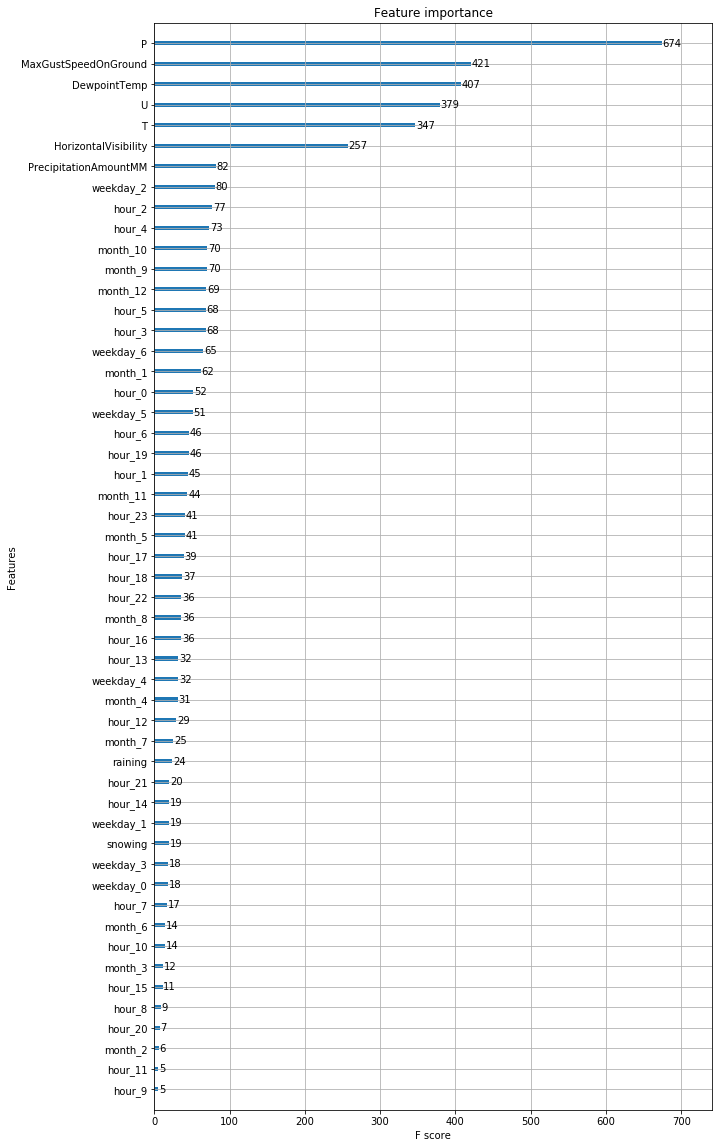

In [67]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(111)
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

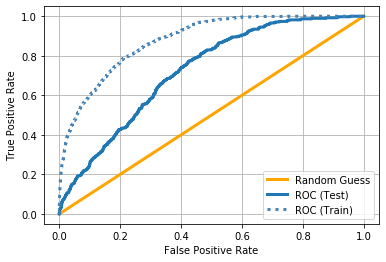

In [68]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()

plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()

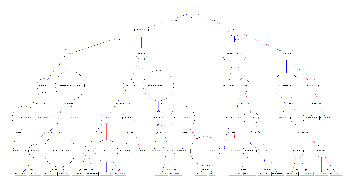

In [69]:
xgboost.plot_tree(booster,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 30]
plt.show()

In [70]:
y_pred_test = booster.predict(dtest) > 0.10
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test)) # TP + TN / (TP + TN + FP + FN)
print ('Test Precision:',precision_score(y_test,y_pred_test)) #TP / (TP + FP)
print ('Test Recall:',recall_score(y_test,y_pred_test)) #TP / (TP + FN)
y_pred_test = booster.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.10
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)


Test Accuracy: 0.9109061038796916
Test Precision: 0.1419068736141907
Test Recall: 0.16753926701570682
Test AUC: 0.7230230231622035
Train Accuracy: 0.9343010345014353
Train Precision: 0.3557347670250896
Train Recall: 0.44556677890011226


<b>Accuracy.</b> Parodo koks procentas spėjimų ar bus avarija ar ne buvo teisingas.<br/>

<b>Recall.</b> Parodo kiek iš nutikusių avarijų modelis nuspėjo, kad avarija nutiks.<br/>

<b>Precision.</b> Parodo kiek procentų atvejų modelis spėjo, kad avarija įvyks ir buvo teisus.<br/>

In [71]:
def plot_split_histogram(feature_name):
    hist = booster.get_split_value_histogram(feature_name)
    try:
        i = float_feature_names.index(feature_name)
        fake_data = np.zeros((hist.Count.size,len(float_feature_names)))
        fake_data[:,i] = hist.SplitValue
        hist.loc[:,feature_name] = scaler.inverse_transform(fake_data)[:,i]
    except: pass
    hist.plot(kind='area',x=feature_name,y='Count')

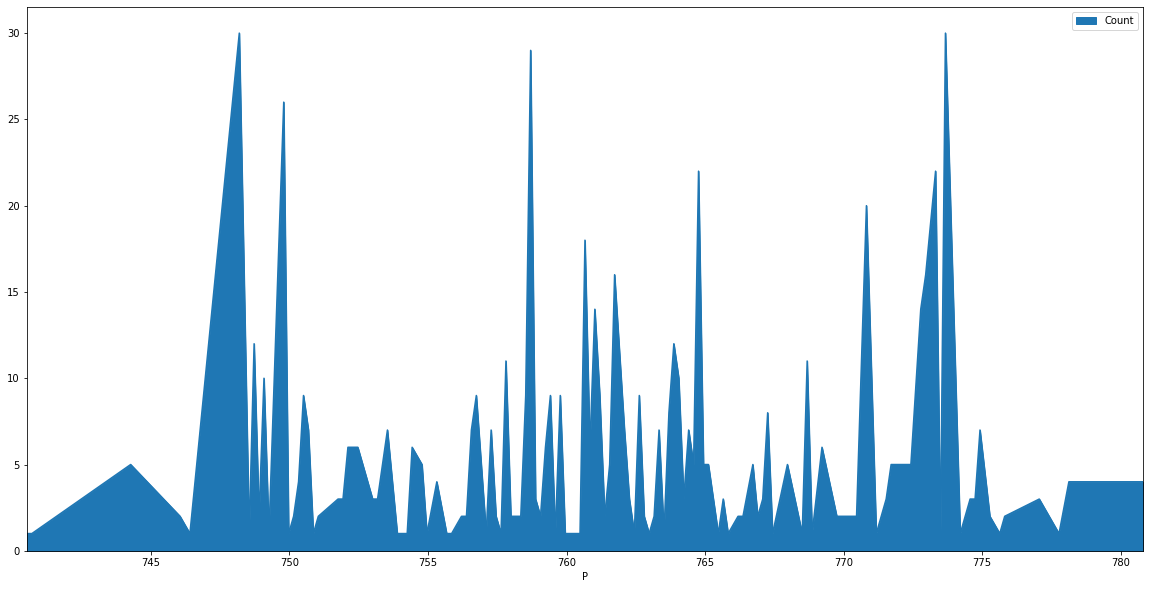

In [72]:
plt.rcParams['figure.figsize'] = [20, 10]
plot_split_histogram('P')

## Kokia tikimybė, kad tam tikrą valandą, esant duotoms oro sąlygoms įvyks eismo avarija Kauno mieste? (xgBoost)

In [74]:
dfInput = pd.read_csv(r'./data_for_using.csv',sep=',',index_col=False)
feature_names = dfInput.columns.tolist()
dfInput

,PrecipitationAmountMM,DewpointTemp,HorizontalVisibility,MaxGustSpeedOnGround,T,U,P,raining,snowing,hour_0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,5,8,10,11,-5,95,748,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
feature_sel = range(len(feature_names))
x = dfInput.values
Xs = x[:,feature_sel]
fnames = np.array(feature_names)[feature_sel]
fnames

array(['PrecipitationAmountMM', 'DewpointTemp', 'HorizontalVisibility',
       'MaxGustSpeedOnGround', 'T', 'U', 'P', 'raining', 'snowing',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'], dtype='<U21')

In [76]:
dmatrix = xgboost.DMatrix(Xs, feature_names=fnames)
prediction = booster.predict(dmatrix)
prediction

array([0.08476956], dtype=float32)

## Išvados, pastebėjimai

* Skaičiavimams naudota orų stotelę, kuri geriausiai nusako orus tame plote. Tačiau didesnį tikslumą galima gauti atlikus interporliavimą tarp stotelių ir taip sudarant klimatologinį žemėlapį.
* Gautas modelis gali būti panaudotas prognozuojant kritulius esant ar būsiant tam tikroms oro sąlygoms. 
* Avarijų prognozavimo modelis rodo, kad didžiausią įtaką, sprendžiant ar nutiks eismo avarija turi oro slėgis. Tai galima paaiškinti tuo, kad slėgis lemia ir kitų oro sąlygų susidarymą: kritulius, rūką, debesuotumą.
* Gautas eismo avarijų prognozavimo modelis leidžia nustatyti eismo avarijos Kauno mieste tikimybę tam tikru laiku esant tam tikroms oro sąlygoms.
* Modelio tikslumas nėra didelis, todėl jį reiktų papildyti įvertinant papildomus veiksnius: kelio būklę, kelio geometrijos parametrus, dėmesį blaškančius veiksnius (reklaminius stendus, augmeniją) ir kitus.
* Modelį apjungus su kelių tinklu galima sudaryti modelį, kuris leistų prognozuoti avarijos tikimybę konkrečiuose Kauno miesto keliuose. O toks modelis galėtų būti panaudotas planuojant pagalbos tarnybų išdėstymą mieste esant tam tikroms oro sąlygoms.